<a href="https://colab.research.google.com/github/TheOctoMizer/AAI-510-Project/blob/main/final-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Business Understanding

Twitter sentiment analysis helps brands, governments, and researchers understand public opinion in real time.

**Business Need:** Build a multilingual sentiment classifier (English, French, Portuguese) that classifies tweets as:
- Positive
- Negative

This will enable:
- Monitoring brand perception
- Tracking political sentiment
- Analyzing feedback across diverse markets

## 2. Data Understanding

You have 3 datasets:
- 🇬🇧 English: 100k+ samples with text and sentiment
- 🇫🇷 French: ~9 lakh samples, but lacks "neutral"
- 🇵🇹 Portuguese: ~6 lakh samples

Challenges:
- Label format inconsistencies (e.g., 0/1/2, strings)
- Extra columns
- Missing/imbalanced classes

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

## 3. Data Preparation

Steps:
- Clean column formats
- Drop extra columns
- Map labels to 'positive'/'negative'
- Remove neutral samples
- Stratified downsample to 65k per language
- Combine into 195k multilingual dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/My Drive/AAI-510-Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def stratified_downsample(df, sample_size):
    label_dist = df['label'].value_counts(normalize=True).to_dict()
    samples = []
    for label, ratio in label_dist.items():
        n = int(sample_size * ratio)
        part = df[df['label'] == label].sample(n=n, random_state=42)
        samples.append(part)
    return pd.concat(samples).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
import pandas as pd

# ------------------------
# 🟢 1. Portuguese Dataset
# ------------------------

def process_portuguese(input_path, output_path):
    df = pd.read_csv(input_path, sep=';', quoting=3, encoding='utf-8', on_bad_lines='skip')

    # Keep only necessary columns
    df = df[['tweet_text', 'sentiment']]
    df.columns = ['text', 'label']
    df['language'] = 'pt'

    label_map = {
        '0': 'negative', '1': 'positive', '2': 'neutral',
        0: 'negative', 1: 'positive', 2: 'neutral'
    }
    df['label'] = df['label'].map(label_map)
    df = df[df['label'].isin(['positive', 'negative'])]
    df.info()
    # Stratified downsample
    sampled = stratified_downsample(df, 65000)
    sampled.to_csv(output_path, index=False)
    print(f"✅ Portuguese dataset saved: {output_path}")

In [ ]:
# --------------------
# 🟢 2. English Dataset
# --------------------

def process_english(input_path, output_path):
    df = pd.read_csv(input_path)
    df = df[['Text', 'Label']]
    df.columns = ['text', 'label']
    df['language'] = 'en'

    df['label'] = df['label'].astype(str).str.lower().str.strip()
    df = df[df['label'].isin(['positive', 'negative'])]

    sampled = stratified_downsample(df, 65000)
    sampled.to_csv(output_path, index=False)
    print(f"✅ English dataset saved: {output_path}")

In [ ]:
# -------------------
# 🟢 3. French Dataset
# -------------------

def process_french(input_path, output_path):
    df = pd.read_csv(input_path)
    df = df[['text', 'label']]
    df.columns = ['text', 'label']
    df['language'] = 'fr'

    label_map = {
        '0': 'negative', '1': 'positive', '2': 'neutral',
        0: 'negative', 1: 'positive', 2: 'neutral'
    }
    df['label'] = df['label'].map(label_map)
    df = df[df['label'].isin(['positive', 'negative'])]

    sampled = stratified_downsample(df, 65000)
    sampled.to_csv(output_path, index=False)
    print(f"✅ French dataset saved: {output_path}")

In [ ]:
process_portuguese(f"{base_path}/portuguese.csv", f"{base_path}/portuguese_cleaned_65k.csv")
process_english(f"{base_path}/english.csv", f"{base_path}/english_cleaned_65k.csv")
process_french(f"{base_path}/french.csv", f"{base_path}/french_cleaned_65k.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 65470 entries, 0 to 65469
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      65470 non-null  object
 1   label     65470 non-null  object
 2   language  65470 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB
✅ Portuguese dataset saved: /content/drive/My Drive/AAI-510-Dataset/portuguese_cleaned_65k.csv
✅ English dataset saved: /content/drive/My Drive/AAI-510-Dataset/english_cleaned_65k.csv
✅ French dataset saved: /content/drive/My Drive/AAI-510-Dataset/french_cleaned_65k.csv


In [ ]:
en = pd.read_csv(f"{base_path}/english_cleaned_65k.csv")
pt = pd.read_csv(f"{base_path}/portuguese_cleaned_65k.csv")
fr = pd.read_csv(f"{base_path}/french_cleaned_65k.csv")

df_all = pd.concat([en, pt, fr])
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all.to_csv(f"{base_path}/multilingual_sentiment_195k.csv", index=False)

print("✅ Combined dataset saved: multilingual_sentiment_195k.csv")

✅ Combined dataset saved: multilingual_sentiment_195k.csv


In [ ]:
# Encode labels
df_all['label_enc'] = df_all['label'].map({'negative': 0, 'positive': 1})

In [ ]:
df_all = df_all.dropna()


## 4. Exploratory Data Analysis

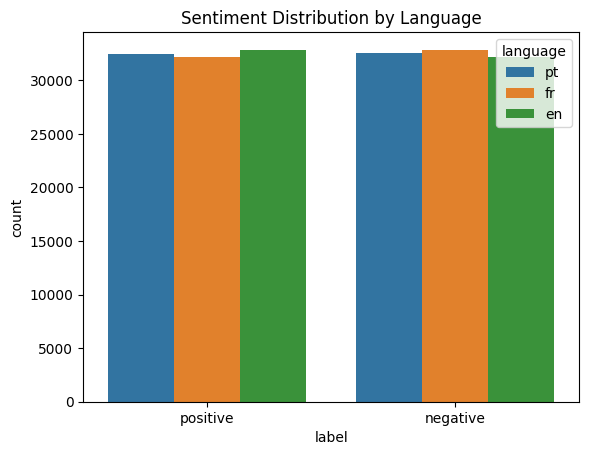

label
negative    97579
positive    97417
Name: count, dtype: int64


In [ ]:
sns.countplot(data=df_all, x='label', hue='language')
plt.title("Sentiment Distribution by Language")
plt.show()

print(df_all['label'].value_counts())

## 5. Modeling

Models to train:
1. XLM-RoBERTa Base
2. MDeBERTa v3 Base
3. DistilBERT Multilingual
4. LSTM

Each model is trained and evaluated on the same train/test split.

In [ ]:
from huggingface_hub import login
login()

### Split the data into traning and test dataset

In [ ]:
train_df, test_df = train_test_split(df_all, test_size=0.2, stratify=df_all['label_enc'], random_state=42)

train_ds = Dataset.from_pandas(train_df[['text', 'label_enc']])
test_ds = Dataset.from_pandas(test_df[['text', 'label_enc']])

In [ ]:
train_df['label_enc'].value_counts()


,count
label_enc,
0,78063
1,77933


### LSTM

## 6. Evaluation

## 7. Final Conclusion

| Model             | Accuracy | F1-Score |
|------------------|----------|----------|
| MDeBERTa v3 Base  | XX.XX%   | XX.XX%   |
| XLM-RoBERTa Base  | XX.XX%   | XX.XX%   |
| DistilBERT Multi  | XX.XX%   | XX.XX%   |
| LSTM              | XX.XX%   | XX.XX%   |

**Insights:**
- MDeBERTa v3 and XLM-RoBERTa gave best multilingual performance.
- DistilBERT is lighter but less accurate.
- LSTM works but lags behind modern transformers.

**Next Steps:**
- Try adding attention to LSTM
- Use more data (with neutral)
- Test on other languages (e.g., Spanish, Hindi)